In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = wobble.Data('hip54287_e2ds.hdf5', filepath='data/')

In [3]:
model = wobble.Model(data)
model.add_star('a')
model.add_telluric('t')
print(model)

Model consisting of the following components: ['a', 't']


Inject some noise & try to get back to the pipeline values by optimizing:

In [4]:
import tensorflow as tf
session = wobble.get_session()
session.run(tf.global_variables_initializer())
pipeline_rvs = session.run(model.components[0].rvs_block[0])
model.components[0].rvs_block[0].load(pipeline_rvs + np.random.normal(0., 100., data.N), session)

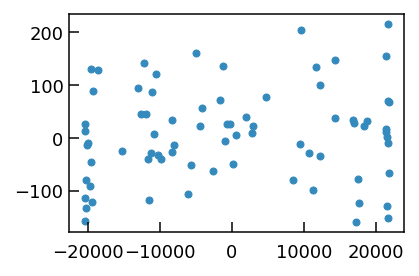

In [5]:
star_rvs = session.run(model.components[0].rvs_block[0])
initial_rvs = np.copy(star_rvs)
plt.scatter(data.pipeline_rvs, star_rvs + data.pipeline_rvs)

In [6]:
nll_history, rvs_history, model_history = wobble.optimize_order(model, data, 0, niter=100, save_history=True)

initializing star model...
initializing tellurics model...
--- ORDER 0 ---


100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


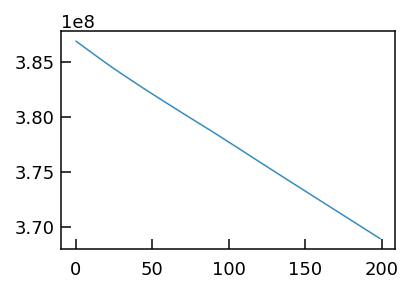

In [7]:
plt.plot(nll_history)

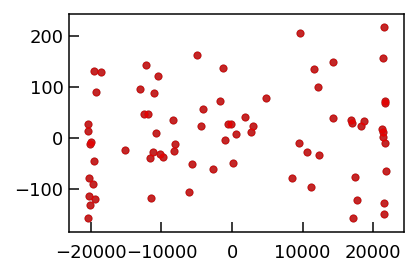

In [8]:
star_rvs = session.run(model.components[0].rvs_block[0])
plt.scatter(data.pipeline_rvs, initial_rvs + data.pipeline_rvs, color='k', alpha=0.6)
plt.scatter(data.pipeline_rvs, star_rvs + data.pipeline_rvs, color='r', alpha=0.6)

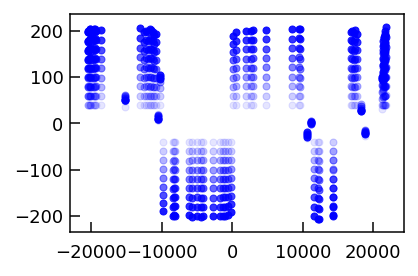

In [9]:
wobble.plot_rv_history(data, nll_history, rvs_history, model_history, 100)